In [1]:
import numpy as np
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt

from sciterra.mapping.atlas import Atlas
from sciterra.mapping.cartography import Cartographer
from sciterra.vectorization.scibert import SciBERTVectorizer

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# atlas_dir = "/Users/nathanielimel/uci/projects/sciterra/src/examples/scratch/outputs/atlas_s2-11-10-23_centered_hafenetal"
# atlas_dir = "/Users/nathanielimel/uci/projects/sciterra/src/examples/scratch/outputs/atlas_s2-11-10-23-sbert_centered_hafenetal"
atlas_dir = "/Users/nathanielimel/uci/projects/sciterra/src/examples/scratch/outputs/atlas_s2-11-11-23_w2v-centered_hafenetal"

In [3]:
atl = Atlas.load(atlas_dir)

No publications to read, skipping.
No projection to read, skipping.
No bad_ids to read, skipping.
No history to read, skipping.
No center to read, skipping.
Loading empty atlas.


In [4]:
atl.history.keys()

dict_keys([])

In [5]:
kernels = atl.history['kernel_size']
kernels.shape

KeyError: 'kernel_size'

In [ ]:
convergence_degrees = list(range(kernels.shape[1])) # the max convergence iteration
# adding 1 because '0' con_d is weird, does not follow the monotonically decreasing relationship of pubs w conv degree


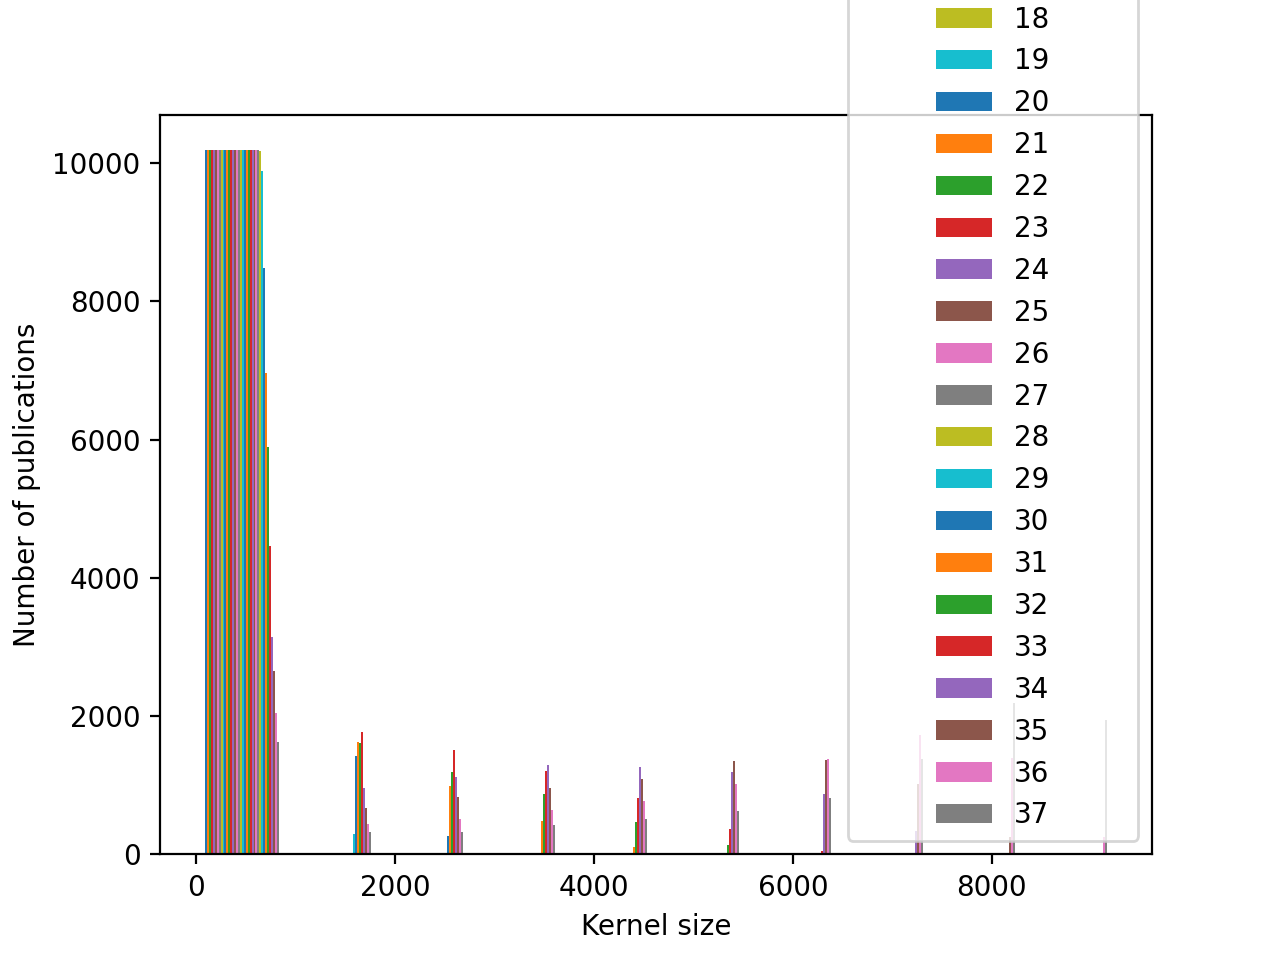

In [ ]:
# plt.hist(x=kernels)

plt.hist(kernels, label=range(kernels.shape[1]))
 
plt.xlabel('Kernel size')
plt.ylabel('Number of publications')
plt.legend(
    title = 'expansion iteration',
)
plt.show()

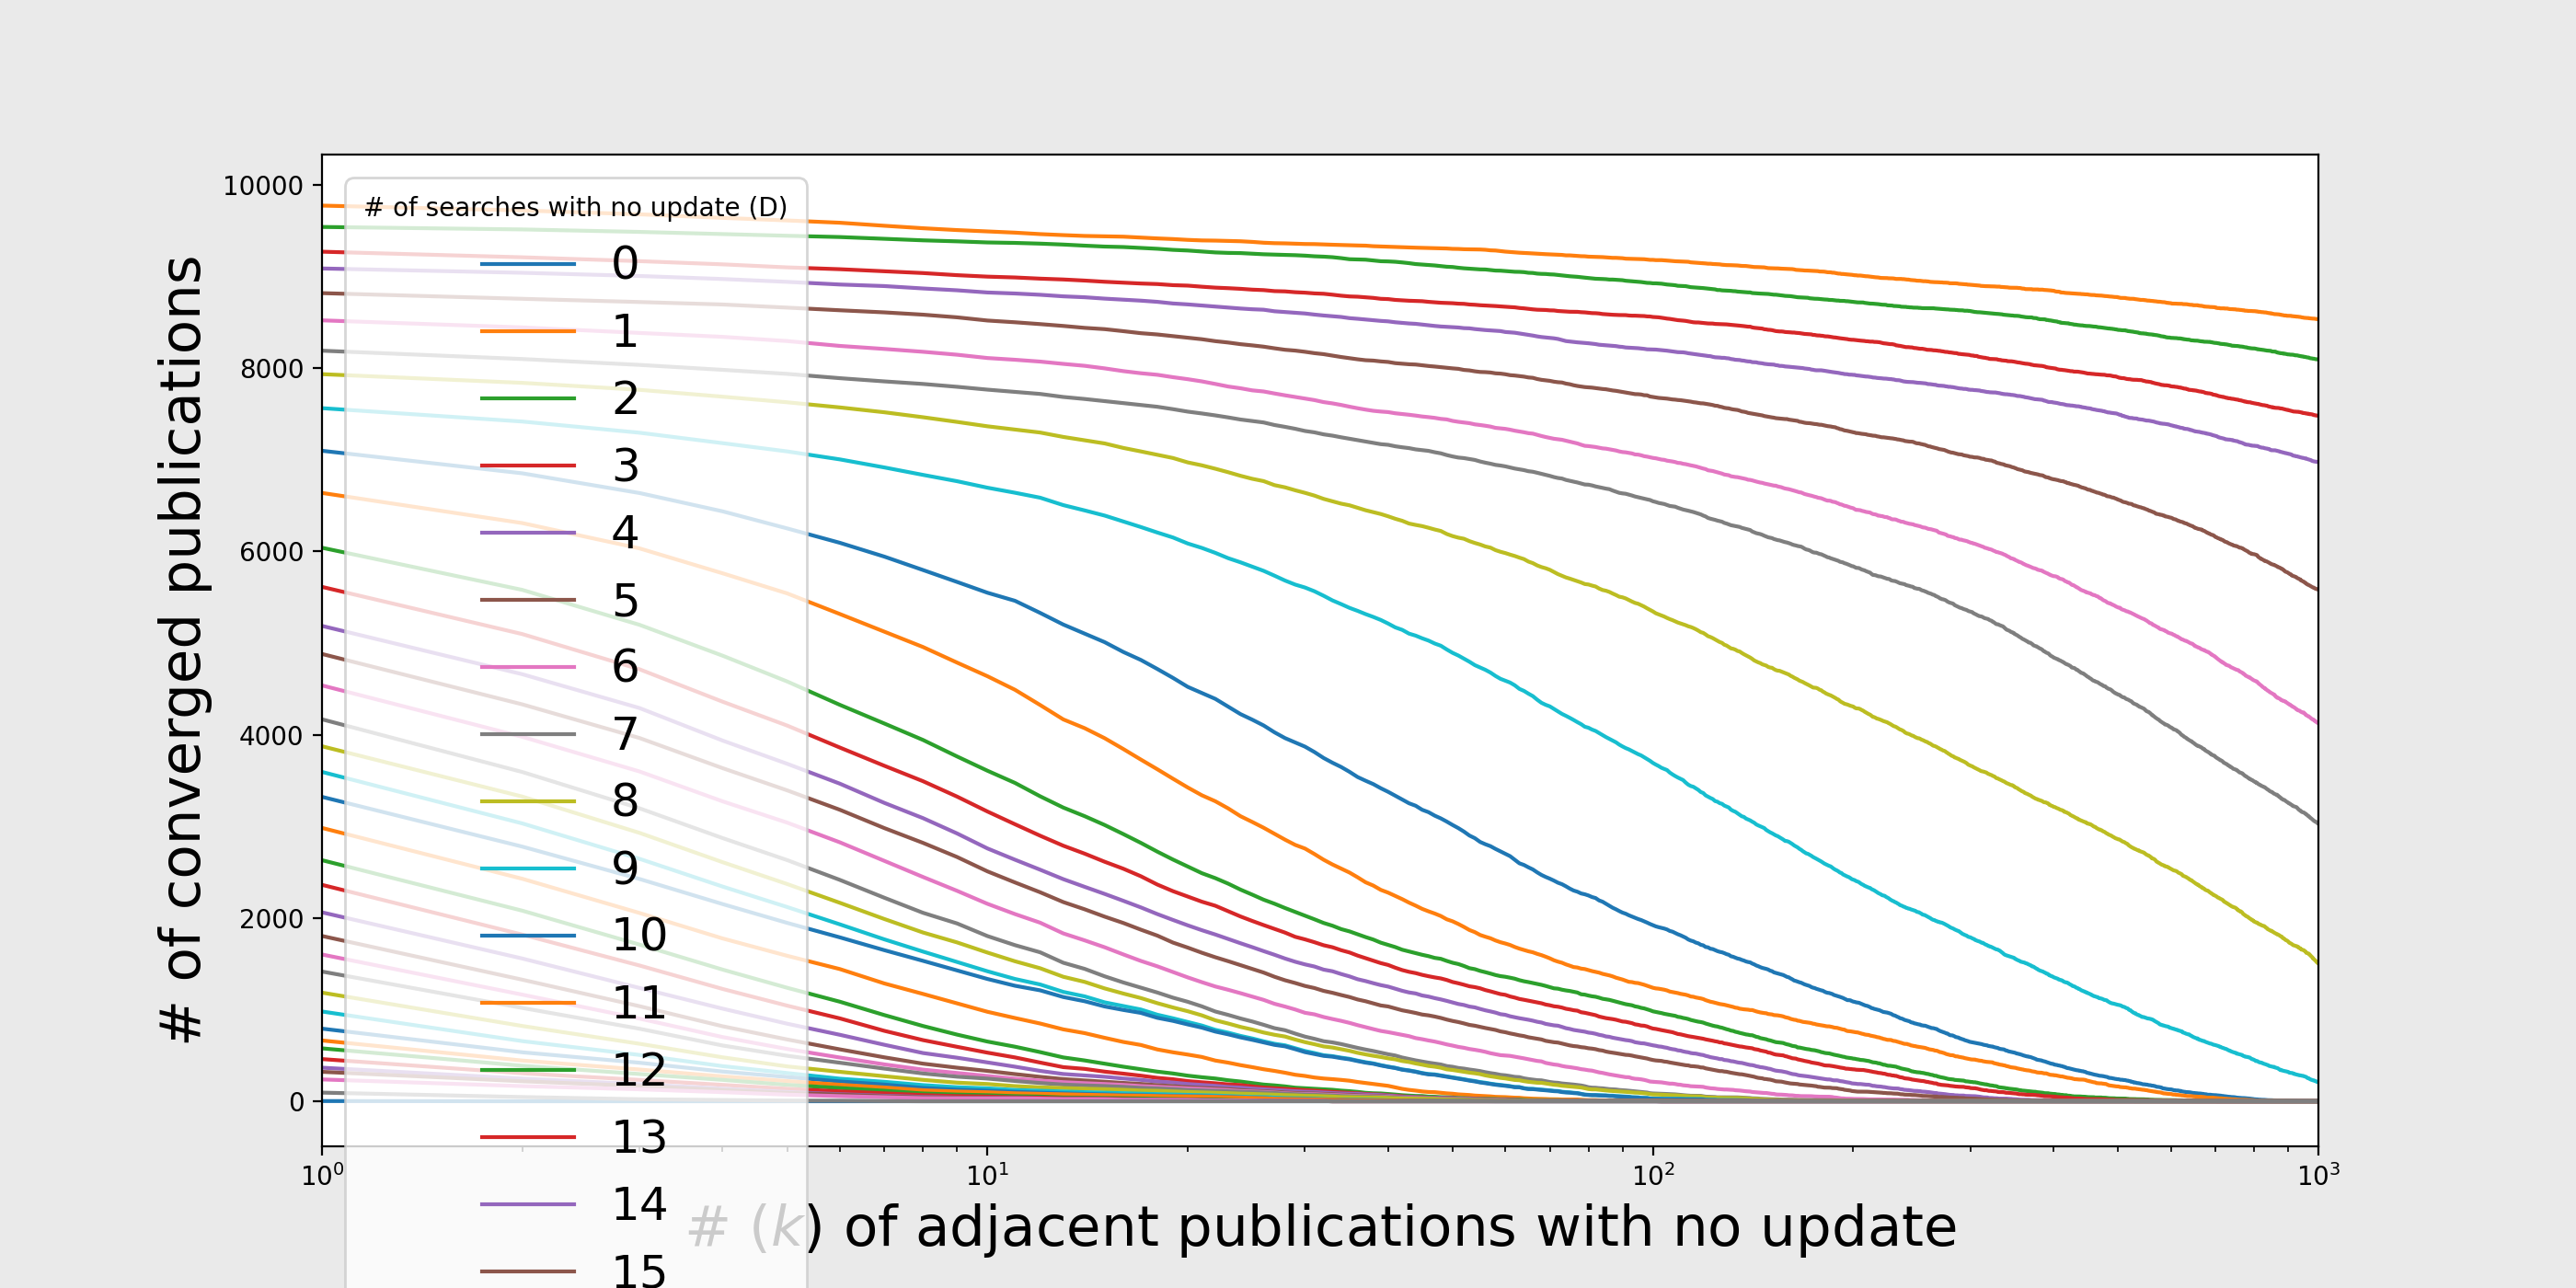

In [ ]:
fig = plt.figure( figsize=(14,7), facecolor=np.array([ 235, 235, 235 ]) / 256. )
ax = plt.gca()

n_total = 0
n_all = 0
n_samples = []

bins = np.arange( -0.5, kernels.max()+1.5, 1. )

for i, con_d in enumerate( convergence_degrees ):

    # Calculate the distribution of kernel sizes
    hist, bins = np.histogram(
        kernels[:,-con_d], # the largest kernel size that hasn't changed since the 3rd to last update, i.e. after 7 updates
        bins = bins,
    )
    centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

    # Calculate the number of publications with that kernel size or more
    cumulative = np.cumsum( hist )
    reverse_cumulative = ( cumulative[-1] - cumulative )
    
    ax.plot(
        centers,
        reverse_cumulative,
        label = con_d,
    )

ax.set_xlim( 1, 1e3, )
# ax.set_ylim( 0, 15000 )
ax.set_xscale( 'log' )

ax.set_xlabel( r'# $(k)$ of adjacent publications with no update', fontsize=22 )
ax.set_ylabel( '# of converged publications', fontsize=22 )
ax.legend(
    prop={'size':18 },
    title = '# of searches with no update (D)',
)

# # Save
# save_fp = 'converged_kernel_size.pdf'
# fig.savefig( save_fp, bbox_inches='tight' )
# print( 'Saved at {}'.format( save_fp ) )

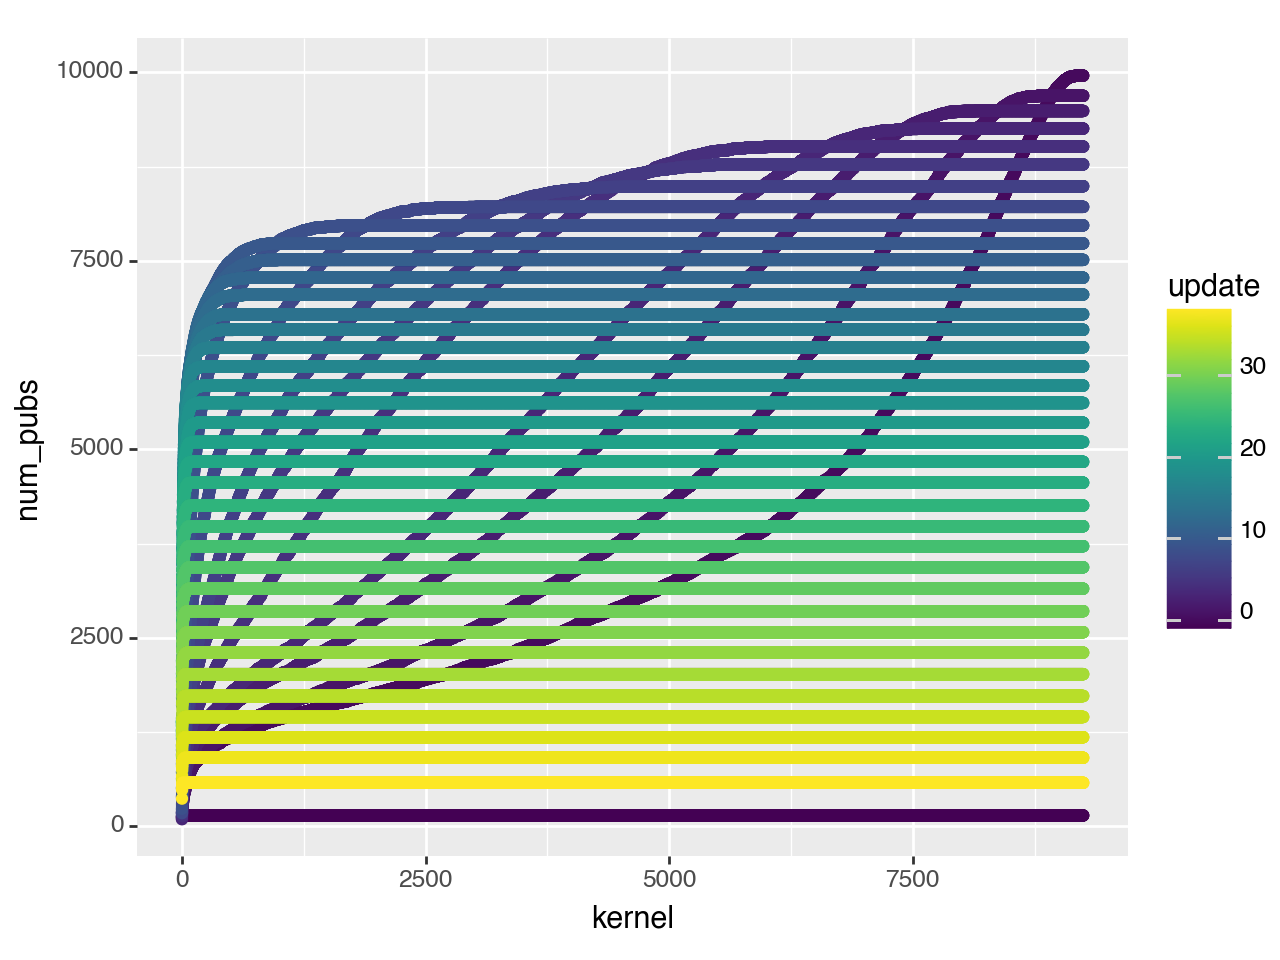

<Figure Size: (640 x 480)>

In [ ]:

dfs = []
for i, con_d in enumerate( convergence_degrees ):

    # Calculate the distribution of kernel sizes
    hist, bins = np.histogram(
        kernels[:,-con_d], # the largest kernel size that hasn't changed since the 3rd to last update, i.e. after 7 updates
        bins = bins,
    )
    centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

    # Calculate the number of publications with that kernel size or more
    cumulative = np.cumsum( hist )
    reverse_cumulative = ( cumulative[-1] - cumulative )

    df = pd.DataFrame(data=zip(centers, cumulative, [con_d]*len(centers)), columns=["kernel", "num_pubs", "update"])
    dfs.append(df)

df = pd.concat(dfs)


(
    pn.ggplot(df, pn.aes(x="kernel", y="num_pubs", color="update"))
    + pn.geom_point()
)


## Filter atlas by converged publications

In [ ]:
# converged_kernel_size = data_k['converged_kernel_size'][:,-pm['convergence_degree']]
# converged = converged_kernel_size >= pm['kernel_size']
# publications = c.publications[converged]
# inds = np.arange( c.publications.size )[converged]

In [ ]:
con_d = 1
kernel_size = 16
converged_filter = kernels[:, -con_d] >= kernel_size
ids = np.array(atl.projection.index_to_identifier)
converged_pub_ids = ids[converged_filter]

[atl[id].title for id in converged_pub_ids][:10]

['Low-redshift Lyman limit systems as diagnostics of cosmological inflows and outflows',
 'KECK SPECTROSCOPY OF FAINT 3 < z < 7 LYMAN BREAK GALAXIES. III. THE MEAN ULTRAVIOLET SPECTRUM AT z ≃ 4',
 'The ESO UVES advanced data products quasar sample – VI. Sub-damped Lyman α metallicity measurements and the circumgalactic medium',
 'Cosmic ray feedback in the FIRE simulations: constraining cosmic ray propagation with GeV γ-ray emission',
 'Predictions for the spatial distribution of the dust continuum emission in $\\boldsymbol {1\\,\\lt\\, z\\,\\lt\\, 5}$ star-forming galaxies',
 'THE KECK + MAGELLAN SURVEY FOR LYMAN LIMIT ABSORPTION. III. SAMPLE DEFINITION AND COLUMN DENSITY MEASUREMENTS',
 'A general class of Lagrangian smoothed particle hydrodynamics methods and implications for fluid mixing problems',
 'Feedback first: the surprisingly weak effects of magnetic fields, viscosity, conduction and metal diffusion on sub-L* galaxy formation',
 'The COS CGM Compendium. II. Metallicities of 

### measure topography of converged pubs


In [ ]:
crt = Cartographer(vectorizer=SciBERTVectorizer())

Using device: cpu.


In [ ]:
measurements = crt.measure_topography(
    atl, 
    ids=converged_pub_ids,
    metrics=["density", "edginess"], 
    kernel_size=kernel_size,
)

computing cosine similarity for 9437 embeddings with batch size 1000.


100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


Computing ['density', 'edginess'] for 9437 publications.


invalid value encountered in divide


In [ ]:
# get citations
citations_per_year = [ 
    atl[id].citation_count / (2023 - atl[id].publication_date.year) if (atl[id].publication_date.year < 2023 and atl[id].citation_count is not None) else 0.
    for id in converged_pub_ids
]
# what if we just drop all those with 0 citations (per year)?
# and those > 100 anyway
# citations_per_year = [item if (item > 0. and item < 100.) else None for item in citations_per_year ]
citations_per_year

[8.857142857142858,
 8.166666666666666,
 10.428571428571429,
 10.6,
 9.0,
 4.125,
 29.454545454545453,
 11.428571428571429,
 5.4,
 6.285714285714286,
 3.3333333333333335,
 6.333333333333333,
 12.285714285714286,
 11.285714285714286,
 1.25,
 5.416666666666667,
 8.666666666666666,
 0.75,
 21.357142857142858,
 13.333333333333334,
 17.0,
 30.125,
 2.6666666666666665,
 2.0,
 14.166666666666666,
 1.5,
 92.6,
 56.65,
 3.0,
 7.538461538461538,
 21.384615384615383,
 27.454545454545453,
 3.6666666666666665,
 17.692307692307693,
 20.166666666666668,
 3.0,
 82.44444444444444,
 17.2,
 6.666666666666667,
 3.909090909090909,
 6.5,
 7.0,
 6.583333333333333,
 1.6666666666666667,
 0.0,
 11.692307692307692,
 5.166666666666667,
 5.357142857142857,
 6.875,
 7.2,
 4.333333333333333,
 1.2,
 13.75,
 2.0588235294117645,
 2.6363636363636362,
 14.941176470588236,
 1.0,
 31.8,
 11.7,
 131.10526315789474,
 2.3333333333333335,
 2.0,
 9.2,
 12.090909090909092,
 7.333333333333333,
 59.3,
 62.421052631578945,
 5.25,
 

In [ ]:
df = pd.DataFrame(
    measurements,
    columns=["density", "edginess"],
)
df["citations_per_year"] = citations_per_year
df.dropna(inplace=True) # not sure why this didn't take care of later NaNs
df.to_csv("stuff.csv")

'stat_bin()' using 'bins = 3752'. Pick better value with 'binwidth'.


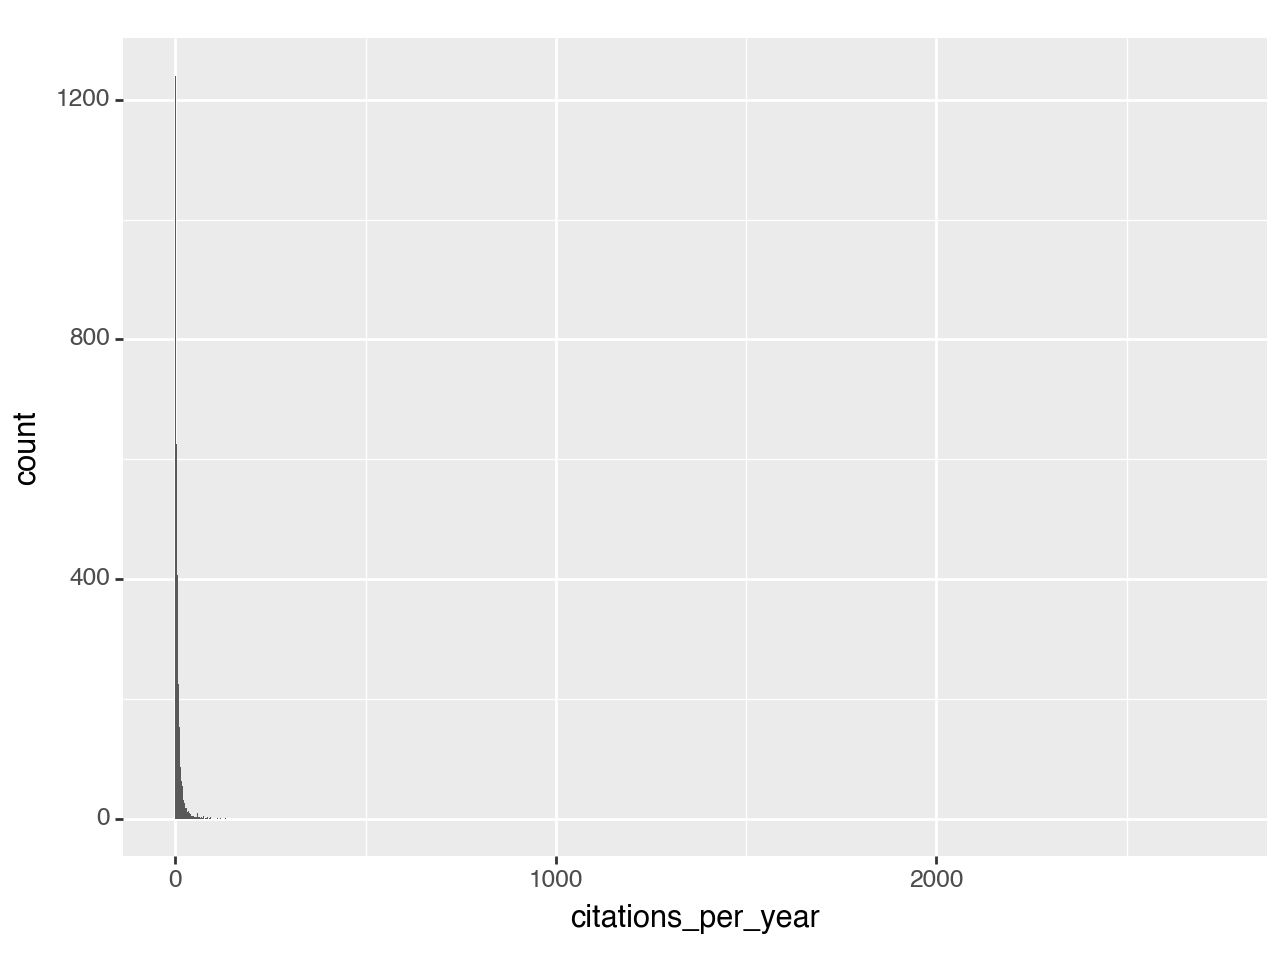

<Figure Size: (640 x 480)>

In [ ]:
# we expect the citation dist to have a long tail; most pubs are not cited at all, or have very few cites, while a handful of publications are extremely heavily cited

(
    pn.ggplot(
        df,
        # df[df["citations_per_year"] <= 25],
        mapping=pn.aes(x="citations_per_year")
    )
    + pn.geom_histogram()
    # + pn.scale_x_log10()
)

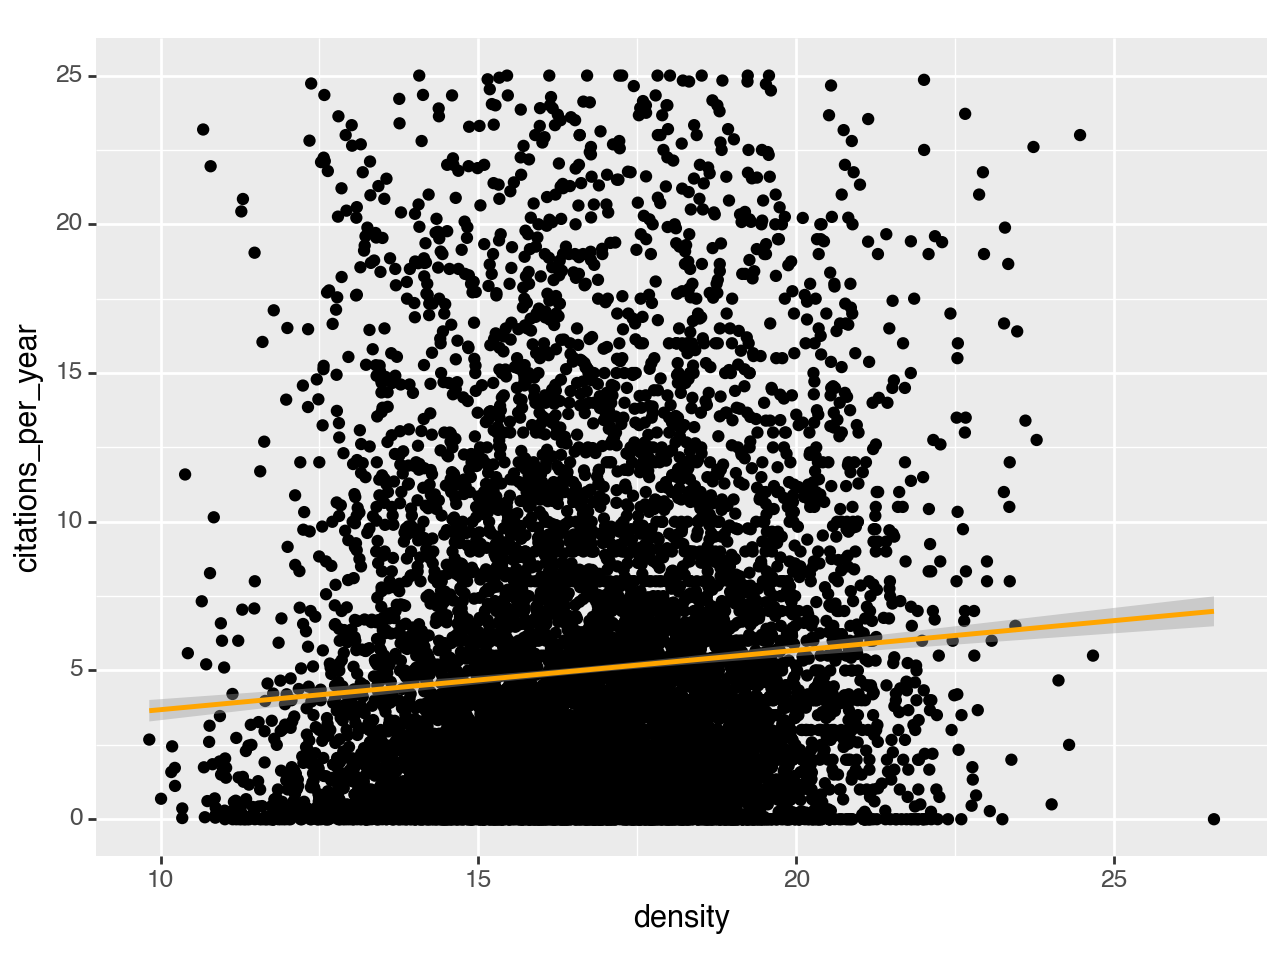

<Figure Size: (640 x 480)>

In [ ]:
(
    pn.ggplot(
        # df,
        df[df["citations_per_year"] <= 25],
        # df[df["citations_per_year"] >= 25],
        mapping=pn.aes(x="density", y="citations_per_year")
    )
    + pn.geom_point()
    + pn.geom_smooth(color="orange")
)